In [3]:
import warnings
warnings.simplefilter('ignore')
import h5py  # API for Heirarchical Data Format files
import numpy as np

from urllib.request import urlretrieve

import sys
sys.path.append('..')

FIGURE_DIR = '.'

# Uncomment below to mess with global matplotlib settings

import matplotlib.pylab as pylab
params = {
     'axes.labelsize': 'x-large',
     'axes.titlesize':'x-large',
     'xtick.labelsize':'x-large',
     'ytick.labelsize':'x-large'
}

pylab.rcParams.update(params)

# Intro

In this notebook we demonstrate how to reproduce our results. In the process, the reader will learn which Python functions produced which datasets, which were used in each figure. 

## Data availability

The data is publically available. You can download a zip file of all the data (~14GB zipped) from 
[this link](http://mt.digital/static/data/polarization_v0.1-data.tar). Save it to the root project directory, one back from this notebook directory.

# Distance measure and social influence

The distance measure introduced by Flache and Macy (2011) (FM from here on) is

$$
d_{ij} = \frac{1}{K}\sum_{k=1}^{K} |s_{jk,t} - s_{ik,t}|
$$

The outcome measure of polarization variance of all $\frac{N(N-1)}{2}$ pairwise distances. Whether two agents are "friends" or "enemies" depends on the sign of the weight

$$
w_{ij} = 1 - d_{ij}.
$$

If $w_{ij} > 0$, then the opinions of agent $i$ is attracted to those of agent $j$, and we can say they are friends. If $w_{ij} < 0$, the agents are not attracted but repelled from each other's opinion. We illustrate this below.

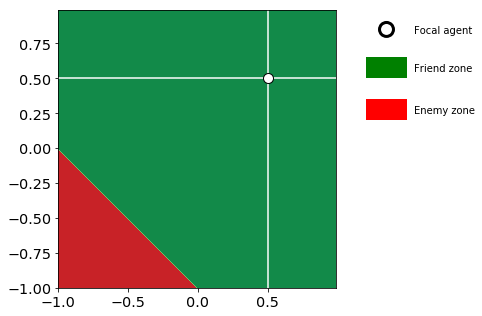

In [3]:
def fm_dist(q1, q2):
    ret = np.absolute(q1 - q2).mean(axis=-1)
    return ret

x = np.arange(-1, 1, 0.01)
y = x.copy()
X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))

# origin = (0.0, 0.0)
origin = (0.5, 0.5)

# def show_dists(origin):

cmap = 'RdYlGn_r'
cmap = 'RdYlGn'

fm_dists = fm_dist(origin, points)

# Plot friend zone and enemy zone
fig, ax = plt.subplots(figsize=(7, 4.5))
c = ax.contourf(
    x, y, (1.0 - fm_dists.reshape(200, 200)) > 0.0, 
    linewidths=3, cmap=cmap
)


ax.set_aspect('equal', adjustable='box')
ax.axhline(0.5, color='white')
ax.axvline(0.5, color='white')
ax.plot(*origin, 'ow', ms=10, mew=1, markeredgecolor='black')


import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
# legend_ax = fig.add_axes([1.05, 0.22, 0.05, 0.55])
# legend_patches = []

friend_rect = mpatches.Rectangle(
    [1.2, 0.5], 0.3, 0.15, ec='none', color='green', clip_on=False
)
enemy_rect = mpatches.Rectangle(
    [1.2, 0.2], 0.3, 0.15, ec='none', color='red', clip_on=False
)
focal_agent = mpatches.Circle([1.35, 0.85], 0.05, ec='black', fc='white', 
                              lw=3, clip_on=False)
ax.add_patch(friend_rect)
ax.add_patch(enemy_rect)
ax.add_patch(focal_agent)

ax.text(1.55, 0.825, 'Focal agent')
ax.text(1.55, 0.55, 'Friend zone')
ax.text(1.55, 0.25, 'Enemy zone')

plt.savefig('/Users/mt/Desktop/friend-enemy-zone.pdf', bbox_inches='tight')

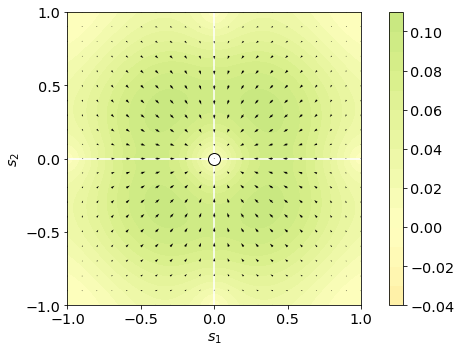

In [13]:
def dyad_force(origin, partner):
    '''
    Calculate pull on origin by partner in dyadic interaction
    '''
    weight = 1.0 - fm_dist(origin, partner)
    raw = 0.5 * weight.transpose() * (origin - partner).transpose()
    
    scaled = raw * (1.0 - np.multiply(np.sign(partner), partner)).transpose()
    
    return scaled


f_vec = dyad_force(np.array((-0.5, 0.5)), np.array((0, 0.5)))
# print(f_vec)
f_mag = np.linalg.norm(f_vec)
# print(f_mag)

cmap = 'RdYlGn'

origin = (0.0, 0.0)
# origin = (0.9, 0.9)

x = np.arange(-1, 1.2, 0.01)
y = x.copy()
X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))

fm_dists = fm_dist(origin, points)

# Plot friend zone and enemy zone
fig, ax = plt.subplots(figsize=(8, 5))

forces = dyad_force(origin, points)
forces = forces.transpose()

forces_norm = np.linalg.norm(forces, axis=1)

L = len(x)
# Change the sign of the force magnitude depending on whether
# dyad relationship friendly or antagonistic.
forces_norm_signed = (np.sign(1 - fm_dists) * forces_norm).reshape(L, L)

c = ax.contourf(
    x, y, forces_norm_signed, 
    15, linewidths=3, cmap=cmap,
    vmin=-0.4, vmax=0.4
)
ax.set_aspect('equal', adjustable='box')
# ax.axhline(0.9, color='white', zorder=1)
# ax.axvline(0.9, color='white', zorder=1)
ax.axhline(0.0, color='white', zorder=1)
ax.axvline(0.0, color='white', zorder=1)
ax.plot(*origin, 'ow', ms=12, mew=1, markeredgecolor='black')

xq = np.arange(-1, 1.2, 0.1)
yq = xq.copy()
Xq, Yq = np.meshgrid(xq, yq)

points = np.column_stack((Xq.ravel(), Yq.ravel()))

forces = dyad_force(origin, points)

forces = forces.transpose()

U = forces[:, 0]
V = forces[:, 1]

ax.quiver(Xq, Yq, U, V, zorder=10, # scale_units='x', #)
          units='xy', scale=2.88)
plt.colorbar(c)
ax.set_xlim(-1.0, 1.0)
ax.set_ylim(-1.0, 1.0)
ax.set_xlabel(r'$s_1$')
ax.set_ylabel(r'$s_2$');

ax.set_yticks(np.arange(-1, 1.01, 0.5))

# Uncomment to see friend-enemy line.
# x = [-1.0, 0.8]
# y = [0.8, -1.0]
# ax.plot(x, y, '--', lw=2, color='black')

# Uncomment to persist the plot to file.
# plt.savefig('quiver_0p9_0p9.pdf', bbox_inches='tight')
plt.savefig('quiver_0_0.pdf', bbox_inches='tight')

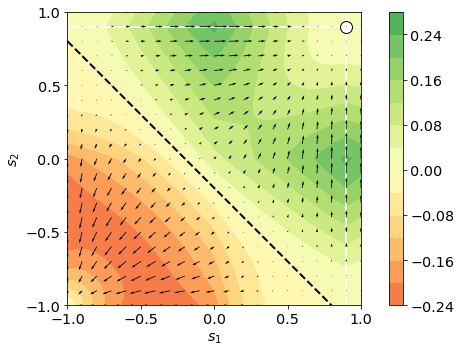

In [11]:
origin = (0.9, 0.9)

x = np.arange(-1, 1.2, 0.01)
y = x.copy()
X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))

fm_dists = fm_dist(origin, points)

# Plot friend zone and enemy zone
fig, ax = plt.subplots(figsize=(8, 5))

forces = dyad_force(origin, points)
forces = forces.transpose()

forces_norm = np.linalg.norm(forces, axis=1)

L = len(x)
# Change the sign of the force magnitude depending on whether
# dyad relationship friendly or antagonistic.
forces_norm_signed = (np.sign(1 - fm_dists) * forces_norm).reshape(L, L)

c = ax.contourf(
    x, y, forces_norm_signed, 
    15, linewidths=3, cmap=cmap,
    vmin=-0.4, vmax=0.4
)
ax.set_aspect('equal', adjustable='box')
ax.axhline(0.9, color='white', zorder=1)
ax.axvline(0.9, color='white', zorder=1)
# ax.axhline(0.0, color='white', zorder=1)
# ax.axvline(0.0, color='white', zorder=1)
ax.plot(*origin, 'ow', ms=12, mew=1, markeredgecolor='black')

xq = np.arange(-1, 1.2, 0.1)
yq = xq.copy()
Xq, Yq = np.meshgrid(xq, yq)

points = np.column_stack((Xq.ravel(), Yq.ravel()))

forces = dyad_force(origin, points)

forces = forces.transpose()

U = forces[:, 0]
V = forces[:, 1]

ax.quiver(Xq, Yq, U, V, zorder=10, # scale_units='x', #)
          units='xy', scale=2.74)
plt.colorbar(c)
ax.set_xlim(-1.0, 1.0)
ax.set_ylim(-1.0, 1.0)
ax.set_xlabel(r'$s_1$')
ax.set_ylabel(r'$s_2$');

ax.set_yticks(np.arange(-1, 1.01, 0.5))

# Uncomment to see friend-enemy line.
x = [-1.0, 0.8]
y = [0.8, -1.0]
ax.plot(x, y, '--', lw=2, color='black')

# Uncomment to persist the plot to file.
plt.savefig('quiver_0p9_0p9.pdf', bbox_inches='tight')
# plt.savefig('quiver_0_0.pdf', bbox_inches='tight')

# Network structure

Connected caveman and random connected caveman.

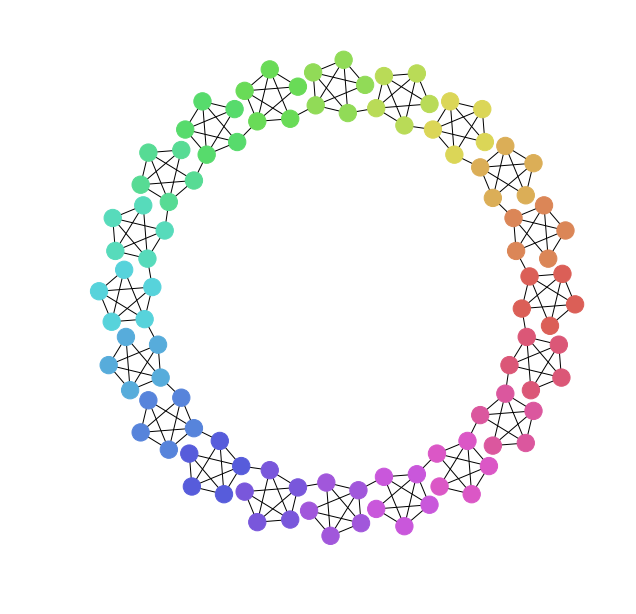

In [4]:
from vis_graph_connection import vis_graph

vis_graph(20, 5, l=1.5)

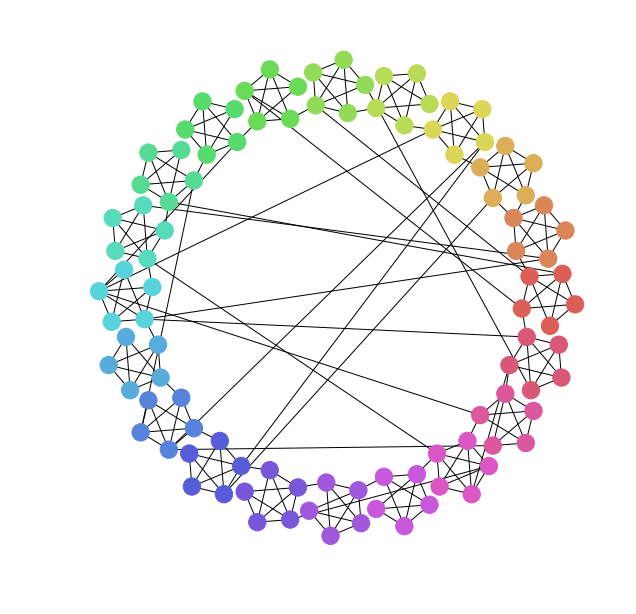

In [5]:
vis_graph(20, 5, l=1.5, randomize=20)

# Final polarization is sensitive to update path & initial agent opinions

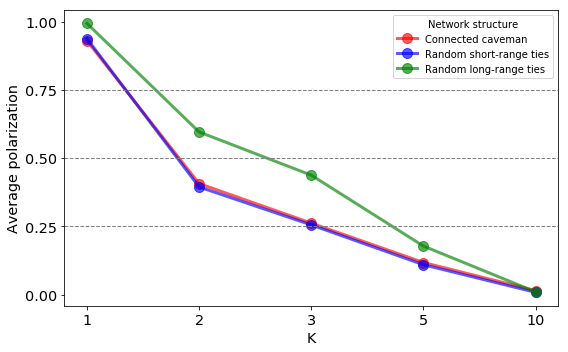

In [6]:
from complexity_analysis import plot_figure12b
data_dir = os.path.join('..', 'data', 'experiments_over_K')
plot_figure12b(data_dir, stddev='off', 
               full_ylim=True, x=[1, 2, 3, 5, 10],
               save_path='p_vs_K_fm.pdf',
               figsize=(8, 5), lw=3)

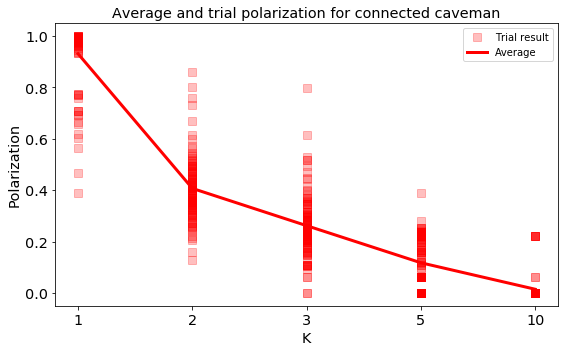

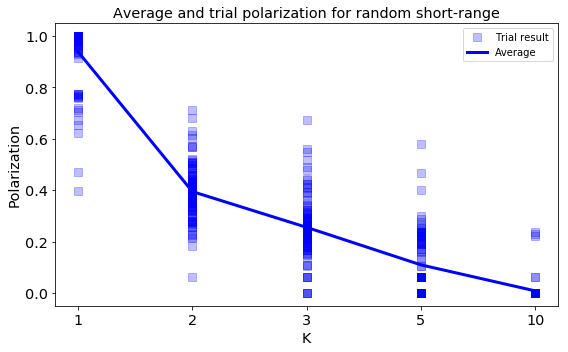

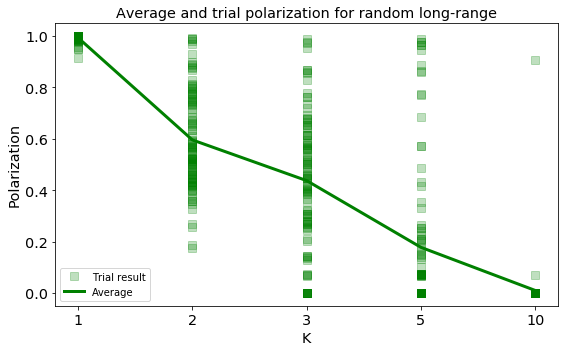

In [7]:
from complexity_analysis import plot_single_K_experiment

data_dir = os.path.join('..', 'data', 'experiments_over_K')
plot_single_K_experiment(data_dir, 'connected caveman', figsize=(8, 5),
                         save_path='connected-caveman-over-K.pdf', lw=3)
plot_single_K_experiment(data_dir, 'random short-range', figsize=(8, 5),
                         save_path='random-short-range-over-K.pdf', lw=3)
plot_single_K_experiment(data_dir, 'random any-range', figsize=(8, 5),
                         save_path='random-long-range-over-K.pdf', lw=3)

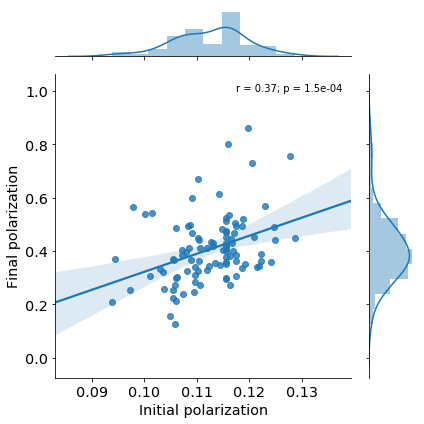

In [8]:
import seaborn as sns
# sns.set(color_codes=False)
from complexity_analysis import _lookup_hdf

data_dir = os.path.join('..', 'data', 'experiments_over_K')

hdf = _lookup_hdf(data_dir, K=2)
cc = hdf['connected caveman']
max_trial_idx = np.argmax(cc['polarization'][:, -1])
# print(max_trial_idx)
# plt.plot(cc['polarization'][max_trial_idx])
# list(cc.keys())

initial_pols = cc['polarization'][:, 0]
final_pols = cc['polarization'][:, -1]

sns.jointplot(x=initial_pols, y=final_pols, kind='reg', 
              annot_kws=dict(stat='r', template='{stat} = {val:.2g}; p = {p:.1e}', frameon=False))
plt.xlabel('Initial polarization')
plt.ylabel('Final polarization')
plt.savefig('final-initial-pol-regplot.pdf', bbox_inches='tight')

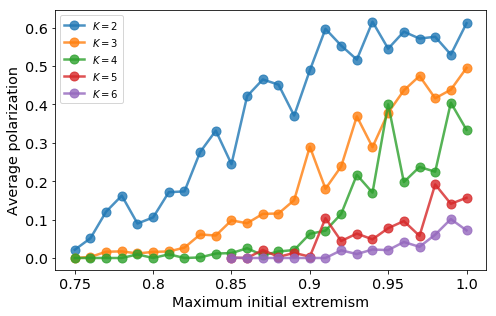

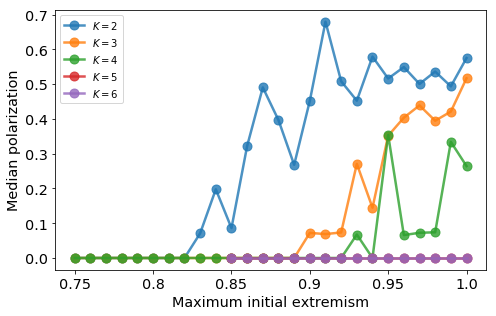

In [9]:
from complexity_analysis import plot_S_K_experiment

data_dir = os.path.join('..', 'data', 'initial_extremism')

plot_S_K_experiment(data_dir, figsize=(7, 4.5), lim_xticks=True,
                    agg_fun=np.mean, save_path='s_k_zoom_2-6_mean.pdf', ms=9, lw=2.5, alpha=0.8)

plot_S_K_experiment(data_dir, figsize=(7, 4.5), lim_xticks=True,
                    agg_fun=np.median, save_path='s_k_zoom_2-6_median.pdf', ms=9, lw=2.5, alpha=0.8)

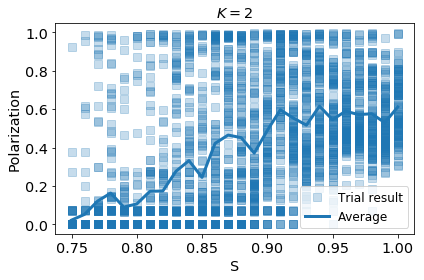

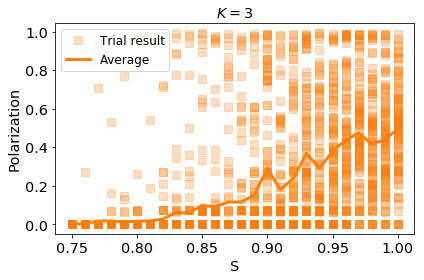

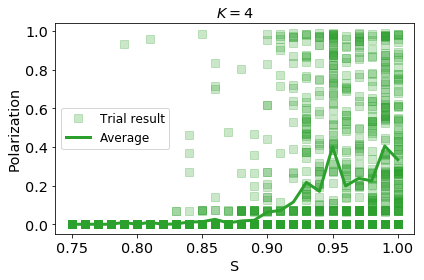

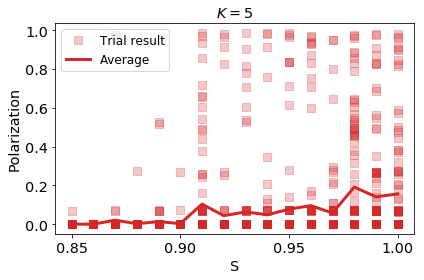

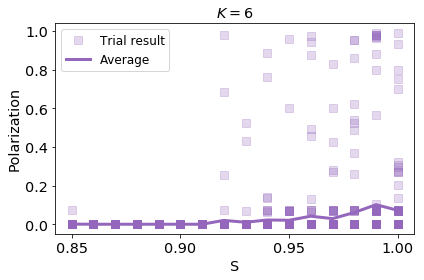

In [10]:
from complexity_analysis import plot_single_S_K

data_dir = os.path.join('..', 'data', 'initial_extremism')

figsize = (8, 5)
pylab.rcParams.update({'legend.fontsize': 'large'})
plot_single_S_K(data_dir, 2, lw=3, save_path='single_S_K_2.pdf')
plot_single_S_K(data_dir, 3, lw=3, save_path='single_S_K_3.pdf')
plot_single_S_K(data_dir, 4, lw=3, save_path='single_S_K_4.pdf')
plot_single_S_K(data_dir, 5, lw=3, save_path='single_S_K_5.pdf')
plot_single_S_K(data_dir, 6, lw=3, save_path='single_S_K_6.pdf')

# Monte Carlo simulation to determine mean and PDF of polarization

Because it seems extreme corners may be important, we do a final computational experiment to see if a combinatorial estimation of the probability density function (PDF) of final polarization. The corners of opinion space are important because of the smoothing factor $(1 - sgn(s_{ik,t})s_{ik,t})$, which makes extreme opinions more "stubborn" than centrist opinions.  Consider the following plots showing that when $S=1$, communication noise cannot break moderate levels of polarization that occur with agents occupying the corners of opinion space.

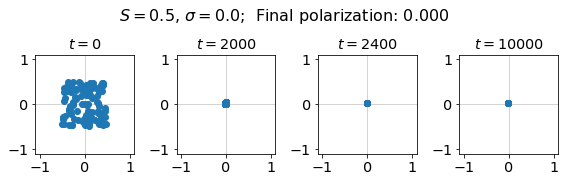

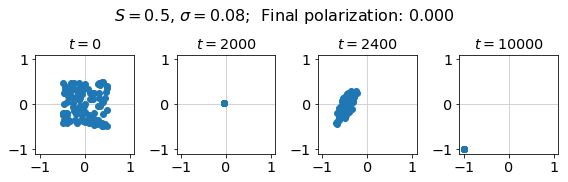

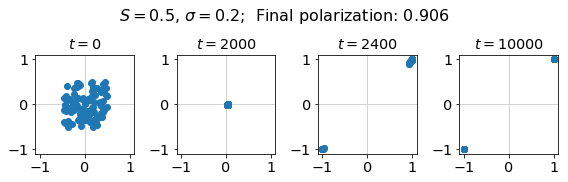

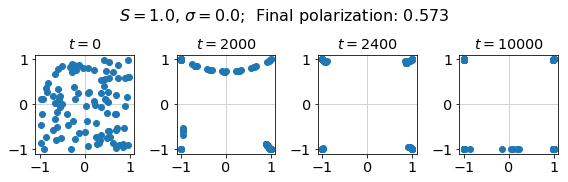

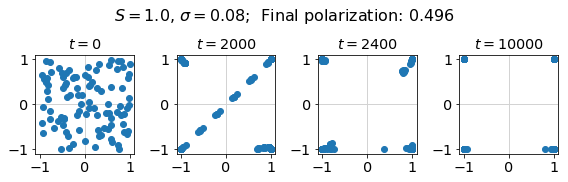

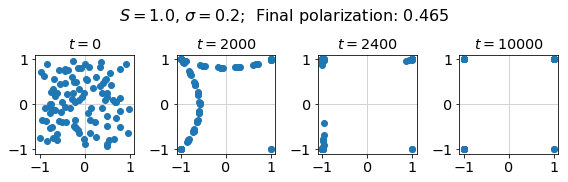

In [11]:
from complexity_analysis import plot_single_noise_example

time_steps = [0, 2000, 2400, 10000]

S = 0.5

ne_dir = os.path.join('..', 'data', 'noise_experiment')

plot_single_noise_example(ne_dir, S=S, noise_level=0.0, 
                          time_steps=time_steps,
                          y_title=0.95, trial_idx=12,
                          save_path='noise_coords_S0p5_n0p0.pdf')

plot_single_noise_example(ne_dir, S=S, 
                          noise_level=0.08, 
                          time_steps=time_steps,
                          trial_idx=30, y_title=.95, 
                          save_path='noise_coords_S0p5_n0p08.pdf')

plot_single_noise_example(ne_dir, S=S, 
                          noise_level=0.20, 
                          time_steps=time_steps,
                          y_title=.95, save_path='noise_coords_S0p5_n0p2.pdf')

S = 1.0

plot_single_noise_example(ne_dir, S=S, noise_level=0.0, 
                          time_steps=time_steps,
                          y_title=.95, trial_idx=12,
                          save_path='noise_coords_S1p0_n0p0.pdf')

plot_single_noise_example(ne_dir, S=S, 
                          noise_level=0.08, 
                          time_steps=time_steps,
                          trial_idx=30, y_title=.95, 
                          save_path='noise_coords_S1p0_n0p08.pdf')

plot_single_noise_example(ne_dir, S=S, 
                          noise_level=0.20, 
                          time_steps=time_steps,
                          y_title=.95, save_path='noise_coords_S1p0_n0p2.pdf')

Now consider the plot below, showing that communication noise does not seem to significantly affect final polarization. If this is because agents are "finding the corners," as the plots above seem to suggest, then perhaps we can count the number of ways agents can assort into each corner, and calculate the polarization for each of those states. An analytical expression is not immediately obvious (to me, at this time), so I will generate many random configurations and calculate the polarization for each configuration, then create the PDF from that data. Ideally this should match well the PDF created below for the random long-range ties with $S=1$ and $\sigma=0$.

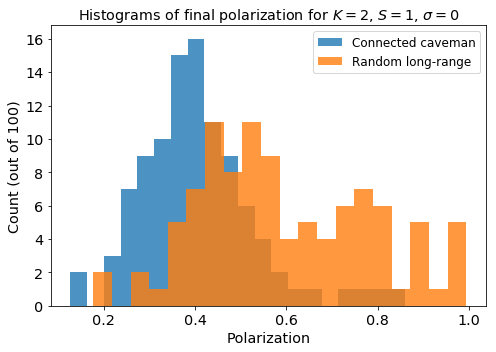

In [12]:
from complexity_analysis import _lookup_hdf

ccpol_address = 'connected caveman/polarization'
rlong_address = 'random any-range/polarization'

data_dir = os.path.join('..', 'data', 'experiments_over_K')

with _lookup_hdf(data_dir, K=2) as hdf:
    # Get the first of 100 trial's initial polarization.
    initial_polarization = hdf[ccpol_address][0, 0]
    # Confirm this is the same for all trials.
    same_ic_forall = np.all(
        initial_polarization == hdf[ccpol_address][:, 0]
    )
    plt.figure(figsize=(7,5))
    plt.hist(hdf[ccpol_address][:, -1], 
             bins=20, alpha=0.8,
             label=r'Connected caveman'
            )
    plt.hist(hdf[rlong_address][:, -1], 
             bins=20, alpha=0.8,
             label='Random long-range'
            )
    plt.ylabel('Count (out of 100)')
    plt.xlabel('Polarization')
    plt.title(r'Histograms of final polarization for $K=2$, $S=1$, $\sigma=0$')
    plt.legend(loc='upper right')

Our combinatorial experiment proceeds as follows. We create a matrix of 100 opinion coordinates taken from the set of corner coordinates, $C$, for a given $K$, defined as 

$$
C = \{ (s_{1}, \ldots, s_{K}) | s_{k} \in \{-1, 1\}\}
$$

Since $C$ is the number of corners for a given $K$, $|C|=2^K$. 

Because certain arrangements of agents into corners are more common, these values of polarization will be favored over others.

In [13]:
import itertools
import numpy as np

from scipy.spatial.distance import cdist


# Adapted from macy/macy.py:polarization. See Equation (3) in 
# Flache and Macy (2011).
def polarization(coords):

    K = len(coords[0])
    X = coords
    N = len(X)

    distances = (1.0 / K) * cdist(X, X, metric='cityblock')

    return distances[np.triu_indices(N, k=1)].var()

def combo_polarizations(Ks=[2, 3, 4, 5, 6], 
                        N_trials=10000, N_agents=100):

    polarizations = {K: 0.0 for K in Ks}

    for K in Ks:
        
        C = np.array(list(itertools.product((-1, 1), repeat=K)))
        coord_idxs = np.random.choice(range(len(C)), (N_trials, N_agents))

        coords = (C[idx] for idx in coord_idxs)

        polarizations[K] = [polarization(c) for c in coords]
    
    return polarizations

In [14]:
pols = combo_polarizations(Ks=[1,2,3,4,5,6,7,8,9,10, 11, 12]);


averages:
 [0.9997966887623712, 0.49993568904397506, 0.33332694289970416, 0.24992044797571675, 0.19993256395551479, 0.16661602468228862, 0.14280724024478963, 0.124980754761759, 0.11110596435244072, 0.09996526055708604, 0.0909196825199655, 0.08329435995068528]

standard deviations:
 [0.0008060591657547499, 0.007401242593985879, 0.005503436008224433, 0.004297080298657923, 0.0036127434332900274, 0.0030584699201396913, 0.0026498892556544684, 0.0023849049020564, 0.0020766441907227335, 0.0018892280521972521, 0.0017383332487327914, 0.0015922350407536695]


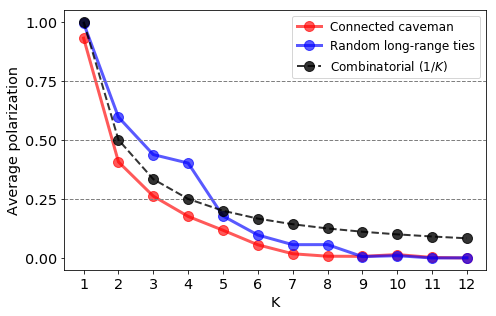

In [15]:
from complexity_analysis import plot_figure12b

Ks = list(range(1, 13))

averages = [np.mean(pols[K]) for K in Ks]
print('\naverages:\n', averages)
stddev = [np.std(pols[K]) for K in Ks]
print('\nstandard deviations:\n', stddev)


data_dir = os.path.join('..', 'data', 'experiments_over_K')

plot_figure12b(data_dir, stddev='off', 
               full_ylim=True, x=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 
               figsize=(7, 4.5),
               experiments=['connected caveman', 'random any-range'],
               save_path='p_vs_K_fm.pdf')
plt.plot(averages, 'o--', ms=10, lw=2, color='black', 
         label=r'Combinatorial ($1/K$)', alpha=0.8)
plt.legend()
plt.savefig('combinatorial-comparison.pdf')

All initial opinion distributions are identical: True
Large IP mean: 0.656
All initial opinion distributions are identical: True
Small IP mean: 0.290


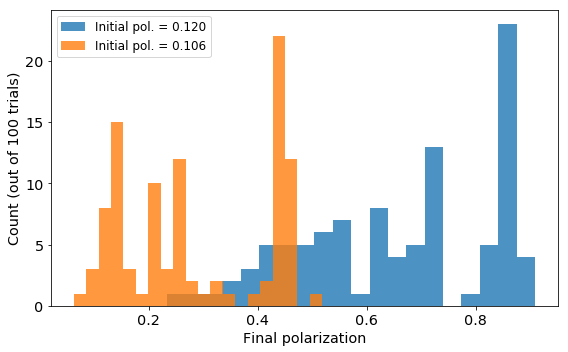

In [16]:
from complexity_analysis import _final_mean
ccpol_address = 'connected caveman/polarization'

plt.figure(figsize=(8, 5))
    
if not os.path.isdir('data'):
    os.mkdir('data')
    
max_filename = os.path.join('data', 'final_rerun_maxpol_K=2.hdf')
min_filename = os.path.join('data', 'final_rerun_minpol_K=2.hdf')


with h5py.File(max_filename, 'r') as hdf:
    # Get the first of 100 trial's initial polarization.
    initial_polarization = hdf[ccpol_address][0, 0]
    # Confirm this is the same for all trials.
    same_ic_forall = np.all(
        initial_polarization == hdf[ccpol_address][:, 0]
    )
    
    print('All initial opinion distributions are identical: {}'.format(
        same_ic_forall
    ))
    print('Large IP mean: {:.3f}'.format(_final_mean(hdf, experiment='connected caveman')))
    
    plt.hist(hdf[ccpol_address][:, -1], 
             bins=20, alpha=0.8,
             label='Initial pol. = {:.3f}'.format(
                 initial_polarization
             )
            )
    

with h5py.File(min_filename, 'r') as hdf:
    initial_polarization = hdf[ccpol_address][0, 0]
    # Confirm this is the same for all trials.
    same_ic_forall = np.all(
        initial_polarization == hdf[ccpol_address][:, 0]
    )
    print('All initial opinion distributions are identical: {}'.format(
        same_ic_forall
    ))
    print('Small IP mean: {:.3f}'.format(_final_mean(hdf, experiment='connected caveman')))
    
    plt.hist(hdf[ccpol_address][:, -1], 
             bins=20, alpha=0.8, 
             label='Initial pol. = {:.3f}'.format(
                 initial_polarization
             )
            )

plt.xlabel('Final polarization')
plt.ylabel('Count (out of 100 trials)')
plt.legend(loc='upper left')
# import matplotlib
# xfmt = matplotlib.ticker.StrMethodFormatter("{x:.1f}")
# plt.gca().xaxis.set_major_formatter(xfmt)
# yfmt = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
# plt.gca().yaxis.set_major_formatter(yfmt)
save_path = os.path.join(FIGURE_DIR, 'caveman_extremes_histograms.pdf')
plt.savefig(save_path)

The files above were created using the following command on the supercomputing cluster. This command calls the `rerun_experiment` subcommand of the `polexp` command line interface (CLI), contained in [scripts/runner.py](scripts/runner.py). The example here runs 100 trials using the initial conditions from the minimum polarization value obtained in the initial $K=2$ run.

```bash
qsub -S /bin/bash -q fast.q -cwd -j y -V -l \
    mem_free=96G -pe smp 20 \
    -N rerun_min_K=2 -o log/rerun_min_K=2.log \
    -e log/err/rerun_min_K=2.err \
    ~/.conda/envs/complexity/bin/polexp rerun_experiment \
    "/scratch/mturner8/finegrained_K_4-18/" "K=2" \
    "/scratch/mturner8/final_rerun_minpol_K=2.hdf" \
    --trial_index=min --n_trials=100 --n_iterations=10000
```

# Polarization is sensitive to communication noise

This was the most data-intensive part, with 762 different parameter configurations, and 100 trial runs for each. Because we tracked opinion coordinates every XX iterations, the files are from 1-20MB each, making for a total of 11GB.

Can download a zipped archive (also 11GB as the component HDF are already compressed) from http://metacorps.io/static/data/noise_experiment.tar.gz. Decompress it to `data/noise_experiment`. 

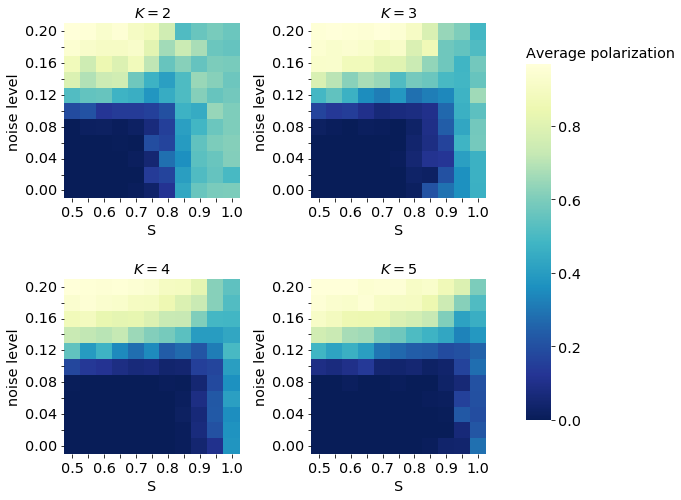

In [17]:
from complexity_analysis import plot_p_v_noise_and_k

ne_dir = os.path.join('..', 'data', 'noise_experiment')

# With pub=True, figure is persisted to noise_experiement_heatmaps.pdf.
plot_p_v_noise_and_k(ne_dir, Ks=[2, 3, 4, 5], pub=True)

Then to understand the distribution of final polarizations for each
of these heatmap cells, we use a different function that makes Cartesian coordinate plots where either `noise level` or `S` is held constant and the other varies along the x-axis. In the examples below we will first hold $S$ at 0.5 and plot final polarization over noise levels. Then we will hold the noise level constant at 0.1 and observe nearly identical average final polarization, but with a considerable number of trials ending in high polarization.

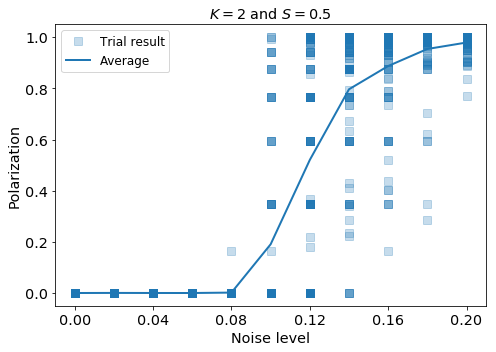

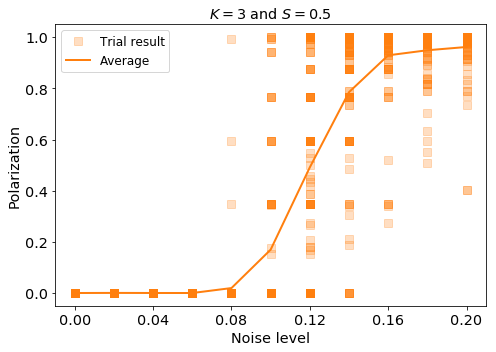

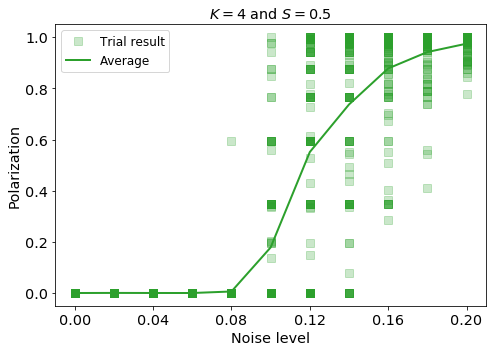

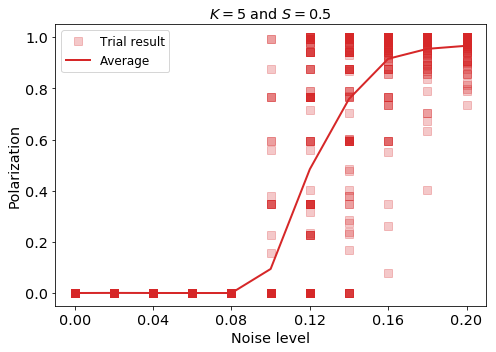

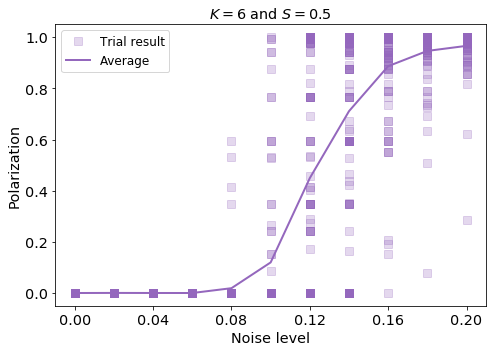

In [18]:
from complexity_analysis import plot_single_noise_param

for K in range(2, 7):
    plot_single_noise_param(
        ne_dir, K, S=0.5, 
#         save_path=FIGURE_DIR + 'noisecomm_S_0p5_K_{}.pdf'.format(K),  # uncomment to save
        figsize=(7, 5))

## Average distance from center with communication noise

With $K=5$, $S=0.5$ and $\sigma=0.1$ it appears that agents become extreme in their opinions, but with consensus. This would be an interesting result if it happened often. To evaluate this, I'm going to create a heatmap of average opinion distance from center. The maximum distance any two agents can be is always 2 because of the $1/K$ normalization in the distance measure, so there is no need to normalize again. 

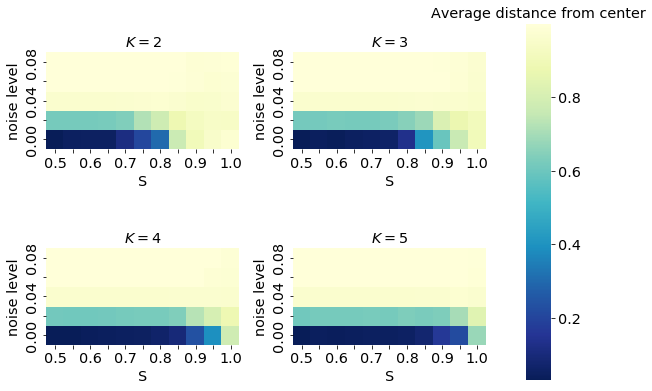

In [19]:
from complexity_analysis import average_distance_heatmap
average_distance_heatmap(ne_dir, Ks=[2, 3, 4, 5], noise_lim=0.1, pub=True)

# Parallel coordinates for visualizing $K > 3$

Parallel coordinates allow us to see the location of many points in $K > 3$-dimensional space. By plotting agent locations in $K$ parallel coordinates over sequential iterations in an experiment trial, we obtain a timeseries plot of agent positions in $K$-dimensional opinion space.

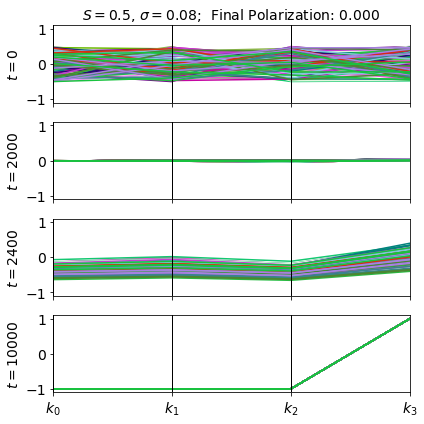

In [20]:
plot_single_noise_example(
    ne_dir, S=0.5, 
    K=4, noise_level=0.08, 
    time_steps=[0, 2000, 2400, 10000],
    y_title=.8, 
    trial_idx=9,
    figsize=(6, 6),
    save_path='commnoise_0p08_K4.pdf'
 )

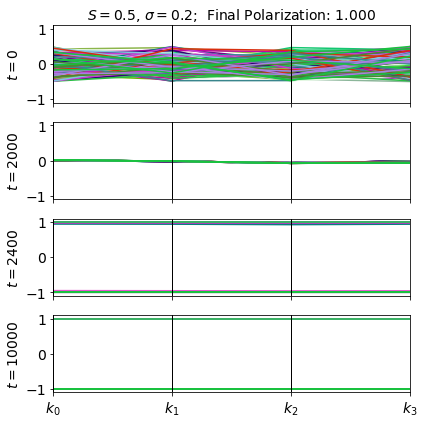

In [21]:
plot_single_noise_example(
    ne_dir, S=0.5, 
    K=4, noise_level=0.2, 
    time_steps=[0, 2000, 2400, 10000],
    y_title=.8, 
    trial_idx=81,
    figsize=(6, 6),
    save_path='commnoise_0p2_K4.pdf'
 )

## Checking convergence

We want to confirm that the simulations have converged. We'll use a helper function to calculate the difference between all final and penultimate polarization values, then calculate the mean and max of the differences for different experiments.

In [ ]:
from complexity_analysis import _hdf_list
def finalpol_diffs(hdf, experiment='random any-range'):
    polarizations = hdf[experiment]['polarization']
    return np.abs(polarizations[:, -1] - polarizations[:, -2])

In [22]:
# Noise experiment
hdfs = _hdf_list('../data/noise_experiment')
all_diffs = np.array([finalpol_diffs(hdf) for hdf in hdfs])

print(all_diffs[~np.isnan(all_diffs)].max())
print(all_diffs[~np.isnan(all_diffs)].mean())

0.0035801481248702305
1.917866636951212e-05


In [23]:
# Initial extremism experiment
try:
    for hdf in hdfs:
        hdf.close()
except:
    pass

hdfs = _hdf_list('../data/initial_extremism/')
all_diffs = np.array([finalpol_diffs(hdf) for hdf in hdfs])
print(all_diffs[~np.isnan(all_diffs)].max())
print(all_diffs[~np.isnan(all_diffs)].mean())

0.0001544479401470178
6.194486149370644e-07


In [24]:
# Over K experiment
try:
    for hdf in hdfs:
        hdf.close()
except:
    pass

hdfs = _hdf_list('../data/experiments_over_K//')
all_diffs = np.array([finalpol_diffs(hdf) for hdf in hdfs])
print(all_diffs[~np.isnan(all_diffs)].max())
print(all_diffs[~np.isnan(all_diffs)].mean())

2.1565548946056445e-05
4.4289732168131116e-07
